In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score #, KFold

from sklearn.feature_selection import mutual_info_regression

In [3]:
df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [4]:
df_train.Transported.describe()

count     8693
unique       2
top       True
freq      4378
Name: Transported, dtype: object

In [5]:
df_train.duplicated().sum()

0

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
features=df_train.columns

numerical_features = df_train._get_numeric_data().columns

categorical_features = list(set(features)-set(numerical_features))

numerical_features = list(set(numerical_features))

In [8]:
# subdivisions of categorical
nominal_features = ['PassengerId', 'GroupId', 'HomePlanet', 'Cabin', 'Name']

ordinal_features = ['Destination', 'Size_of_group', 'DeckNum', 'CabinNum']

binary_features = ['CryoSleep', 'VIP', 'Side']

In [9]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100*(df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
test_total = df_test.isnull().sum().sort_values(ascending=False)
test_percent = 100*(df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent, test_total, test_percent], axis=1, keys=['Train_Total', 'Train_Percent', 'Test_Total', 'Test_Percent'])

missing_data[(missing_data.Train_Total >0) | (missing_data.Test_Total > 0)][ : -1] # as the last is just the missing target from the test data

,Train_Total,Train_Percent,Test_Total,Test_Percent
CryoSleep,217,2.496261,93.0,2.174421
ShoppingMall,208,2.392730,98.0,2.291326
VIP,203,2.335212,93.0,2.174421
HomePlanet,201,2.312205,87.0,2.034136
Name,200,2.300702,94.0,2.197802
Cabin,199,2.289198,100.0,2.338087
VRDeck,188,2.162660,80.0,1.870470
FoodCourt,183,2.105142,106.0,2.478373
Spa,183,2.105142,101.0,2.361468
Destination,182,2.093639,92.0,2.151040


In [10]:
df_train[df_train.Name.isnull()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,0.0,NaN,False
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
65,0069_01,Earth,False,F/16/S,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,0.0,NaN,True
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
101,0108_02,Earth,False,G/19/S,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,B/300/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
8631,9208_01,Earth,True,G/1485/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
8636,9218_01,Europa,True,B/353/S,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
8652,9230_01,Europa,False,C/342/S,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,971.0,NaN,True


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

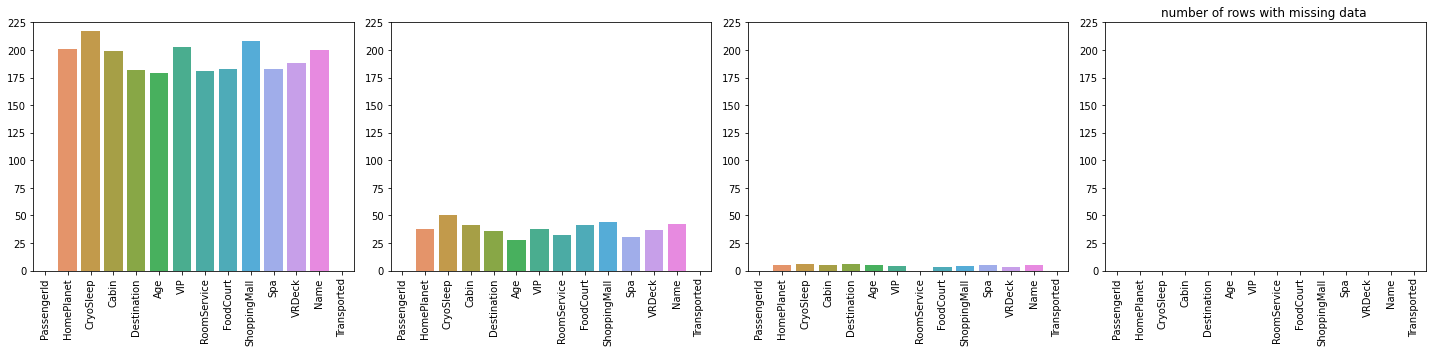

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for n, ax in enumerate(axs.flatten()):
    nan_rows = df_train[df_train.isnull().sum(axis=1) > n].isnull().sum(axis=0)
    sns.barplot(nan_rows.index, nan_rows.values, ax=ax)
    plt.title('number of rows with missing data ')
    ax.set_xticklabels(nan_rows.index, rotation=90)
    ax.set_ylim([0, 225])
fig.tight_layout()

In [12]:
def break_down(df):
    X = df.copy()
    X['GroupId'] = X.PassengerId.str.split("_", expand=True)[0]
    X[['Deck', 'CabinNum', 'Side']] = X.Cabin.str.split("/", expand=True)
    return X

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Side', ylabel='count'>

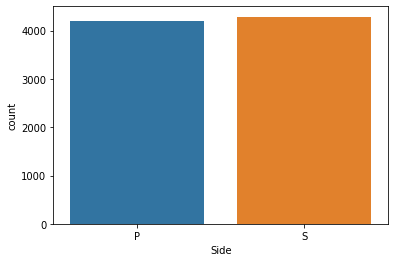

In [13]:
sides=break_down(df_train).Side
sns.countplot(sides)

In [14]:
sides[sides=='S'].count() - sides[sides=='P'].count()

82

- No higher than 2.5% of data in any feature is missing.
- The missing names gave the impression that there were some missing records (with many missing features). But it does this does not appear to be the case with no passenger missing data in more than 3 features and the missing data being pretty evenly distributed between the features.
- With ~200 missing cabin details in our training data and only a 82 person discrepancy between the sides, I did not feel confident to assume that the spaceship was completely symetrical, and even if so, there are too many are missing to know that they would all have been from the lacking side.

Therefore
- Adding a None category for the missing values in the categorical features (other than the VIP and CryoSleep)
- Lack of data implies lack of transaction so imputing zeros into money spent in the various locations appears the best bet.
- Lack of info on wether they were VIPs or in suspended animation also implies that they were not so imputing zeros (False) into those.
- And then imputing the median age as we don't want a bunch of imaginary newborns to feed the model.

In [15]:
def impute(df):
    X = df.copy()
    for col in ['FoodCourt', 'Age', 'ShoppingMall', 'VRDeck', 'Spa', 'RoomService']:
        X[col] = X[col].fillna(0)
    X['Age'] = X['Age'].fillna(df['Age'].median())
    for col in ['CryoSleep', 'VIP']:
        X[col] = X[col].fillna(False)
    for col in ['HomePlanet', 'Cabin', 'Name', 'Destination', 'Deck', 'CabinNum', 'Side']:
        X[col] = X[col].fillna("None")
    return X

In [16]:
print(df_train['HomePlanet'].unique())
print(df_train['Destination'].unique())

['Europa' 'Earth' 'Mars' nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


In [17]:
break_down(df_train).Deck.unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [18]:
def encode(df):
    X=df.copy()
    # based on the distance from Earth I assume this is the route
    X['Destination'] = X['Destination'].map({'PSO J318.5-22': 1, '55 Cancri e': 2, 'TRAPPIST-1e': 3, 'None': 0})
    
    X['Deck'] = X['Deck'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'None':0})
    
    X['GroupId'] = X['GroupId'].astype(int)
    
    # since there arn't many too many features let's one-hot encode the Home Planet
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(X['HomePlanet'].values.reshape(-1,1)))

    # One-hot encoding removed index, so putting it back
    OH_cols.index = X.index
    
    # Naming the new columns based on the old feature and their value
    OH_cols.columns = OH_encoder.get_feature_names(['HomePlanet'])

    # Remove categorical columns no longer needed
    other_X = X.drop('HomePlanet', axis=1)

    # Add one-hot encoded columns to the rest of the features
    X = pd.concat([other_X, OH_cols], axis=1)
    
    # Ordinal Encode the Rest
    To_Encode = ['Cabin', 'CabinNum', 'Name', 'Side']
    ordinal_encoder = OrdinalEncoder()
    X[To_Encode] = ordinal_encoder.fit_transform(X[To_Encode])
    
    X['Transported'] = X['Transported'].astype(bool)

    return X

In [19]:
def load_data():
    df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
    df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
    
    # Merge to process together
    df = pd.concat([df_train, df_test], keys=['train','test'])
    
    # Preprocessing
    df = break_down(df)
    df = impute(df)
    df = encode(df)
    
    # Reform splits
    df_train = df.loc['train']
    df_train.set_index('PassengerId', inplace=True)
    df_test = df.loc['test']
    df_test.set_index('PassengerId', inplace=True)
    return df_train, df_test

In [20]:
def score_dataset(X, y, clf = XGBClassifier(), n=5):
    scores = cross_val_score(clf, X, y, cv=n)
    score = scores.mean()
    return score

In [21]:
df_train_processed , _ = load_data()
df_for_baseline = df_train_processed.copy()
y = df_for_baseline.pop('Transported')

baseline_score = score_dataset(df_for_baseline, y)
print(f"Baseline score: {baseline_score}")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Baseline score: 0.6471984679633481


In [22]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, size=(20,15)):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=size)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

CryoSleep            0.119235
RoomService          0.071797
Spa                  0.058763
ShoppingMall         0.057917
VRDeck               0.054804
FoodCourt            0.035875
Name                 0.029366
Cabin                0.028438
Deck                 0.026260
CabinNum             0.022885
GroupId              0.022187
Age                  0.010918
HomePlanet_Earth     0.010616
Destination          0.008214
Side                 0.002362
VIP                  0.001486
HomePlanet_None      0.001176
HomePlanet_Europa    0.000000
HomePlanet_Mars      0.000000
Name: MI Scores, dtype: float64

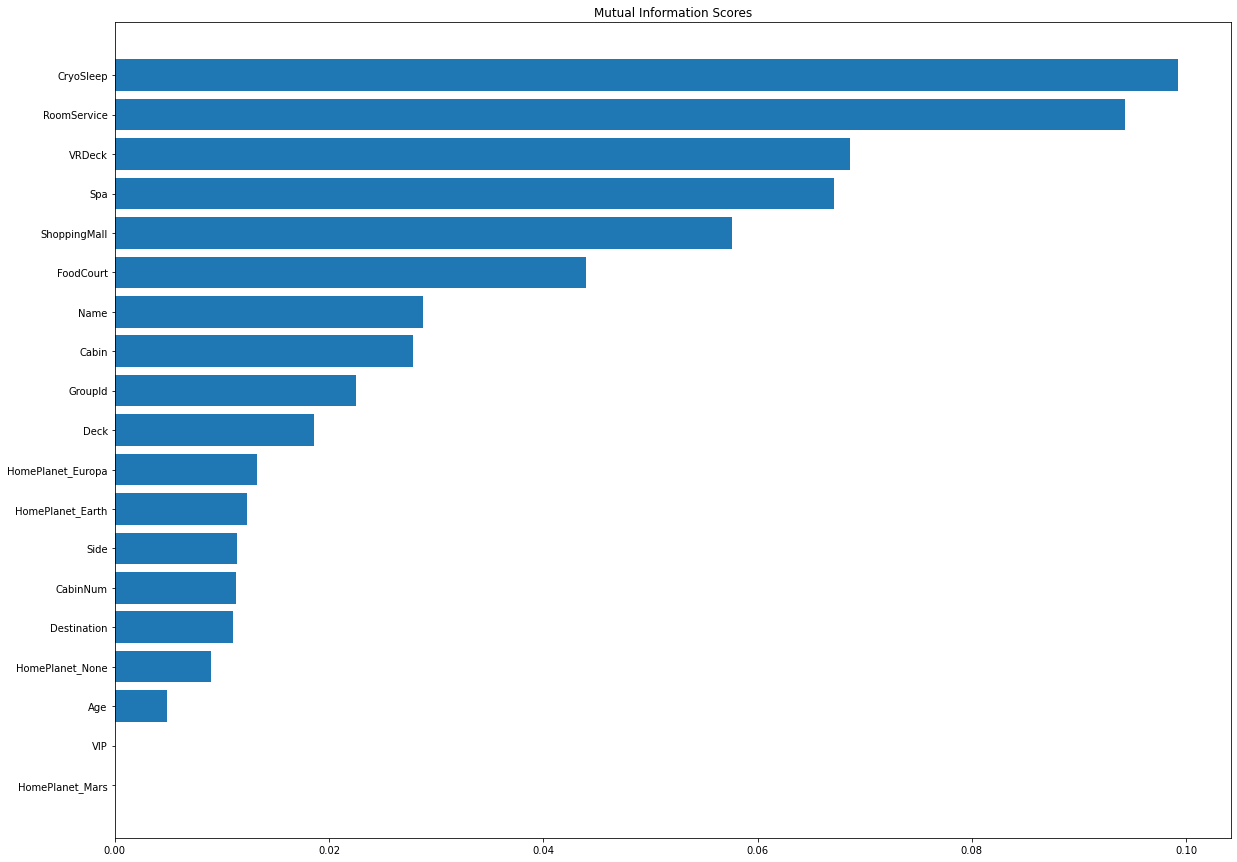

In [23]:
plot_mi_scores(make_mi_scores(df_for_baseline,y))

make_mi_scores(df_for_baseline,y)

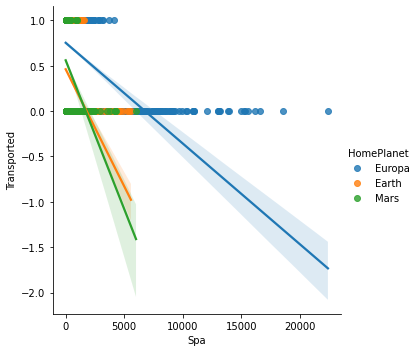

<Figure size 432x288 with 0 Axes>

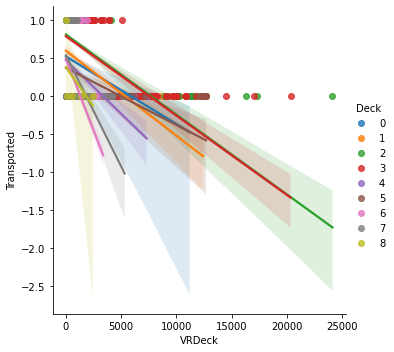

<Figure size 432x288 with 0 Axes>

In [24]:
sns.lmplot(x="Spa", y="Transported", hue="HomePlanet", data=df_train)
plt.show()
plt.clf()

sns.lmplot(x="VRDeck", y="Transported", hue="Deck", data=df_train_processed)
plt.show()
plt.clf()

People from Europa spent more a the Spa etc but no obvious interaction effects stick out. I have left a couple of examples of unhelpful exploration.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Size_of_group', ylabel='count'>

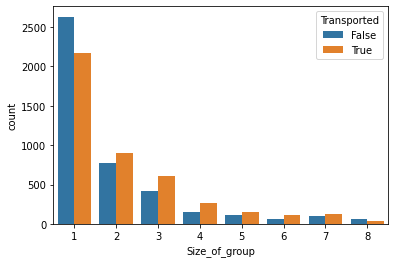

In [25]:
df_train_processed['Size_of_group'] = df_train_processed.groupby(['GroupId'])['GroupId'].transform('count')

sns.countplot(df_train_processed['Size_of_group'], hue=df_train_processed['Transported'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Size_of_group', ylabel='prop_transported_by_group_size'>

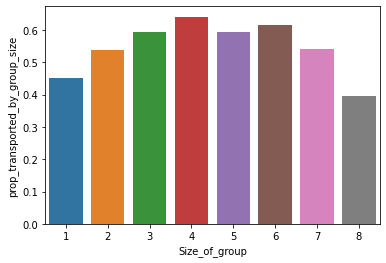

In [26]:
df_train_processed['prop_transported_by_group_size'] = df_train_processed.groupby(['Size_of_group'])['Transported'].transform('sum')/df_train_processed.groupby(['Size_of_group'])['Size_of_group'].transform('count')
sns.barplot(df_train_processed['Size_of_group'], df_train_processed['prop_transported_by_group_size'])

In [27]:
def group_transforms(df):
    df['Size_of_group'] = df.groupby(['GroupId'])['GroupId'].transform('count')
    df['prop_transported_by_group_size'] = df.groupby(['Size_of_group'])['Transported'].transform('sum')/df.groupby(['Size_of_group'])['Size_of_group'].transform('count')
    df['medium_group'] = (df['Size_of_group'] >1) & (df['Size_of_group'] <8)
    return df

In [28]:
def Totalling(df):
    df['Tot_Spend']=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].gt(0.0).sum(axis=1)
    return df

In [29]:
def create_features(df):
    X = df.copy()
    group_transforms(X)
    Totalling(X)
    
    return X

In [30]:
def trial(rem=['VIP', 'RoomService', 'FoodCourt'], clf = XGBClassifier({'max_depth': 6, 'learning_rate': 0.0102657591775899, 'n_estimators': 219, 'subsample': 0.763387008801389, 'gamma': 3.8037093108929487, 'alpha': 0.9994007069133161, 'lambda': 8.96253712351312}), n=5):
    df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
    df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
    
    # Merge to process together
    df = pd.concat([df_train, df_test], keys=['train','test'])
    
    # Preprocessing
    df = break_down(df)
    df = impute(df)
    df = encode(df)
    
    # Creating additional features
    df = create_features(df)
    
    # Removing some features, based on situational evidence and mutual informaion scores
    df = df.drop(rem, axis = 1)
    
    # Reform splits
    df_train = df.loc['train']
    df_train.set_index('PassengerId', inplace=True)
    df_test = df.loc['test']
    df_test.set_index('PassengerId', inplace=True)
    
    X = df_train.copy()
    y = X.pop('Transported')
    score = score_dataset(X, y, clf = XGBClassifier(), n=5)
    print(f'using {clf} with {n} folds')
    print(f"Score: {score}") 
    return score, X, df_train

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


In [31]:
_ , X , df_feature_engineered = trial()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


using XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_s...
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None,
              objective={'alpha': 0.9994007069133161,
                         'gamma': 3.8037093108929487,
                         'lambda': 8.96253712351312,
                         'learning_rate': 0.0102657591775899, 'max_depth': 6,
                         'n_estimators': 219, 'subsample': 0.763387008801389},
              predictor=None, random_state=N

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


using XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_s...
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None,
              objective={'alpha': 0.9994007069133161,
                         'gamma': 3.8037093108929487,
                         'lambda': 8.96253712351312,
                         'learning_rate': 0.0102657591775899, 'max_depth': 6,
                         'n_estimators': 219, 'subsample': 0.763387008801389},
              predictor=None, random_state=N

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


using XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_s...
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None,
              objective={'alpha': 0.9994007069133161,
                         'gamma': 3.8037093108929487,
                         'lambda': 8.96253712351312,
                         'learning_rate': 0.0102657591775899, 'max_depth': 6,
                         'n_estimators': 219, 'subsample': 0.763387008801389},
              predictor=None, random_state=N

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


using XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_s...
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None,
              objective={'alpha': 0.9994007069133161,
                         'gamma': 3.8037093108929487,
                         'lambda': 8.96253712351312,
                         'learning_rate': 0.0102657591775899, 'max_depth': 6,
                         'n_estimators': 219, 'subsample': 0.763387008801389},
              predictor=None, random_state=N

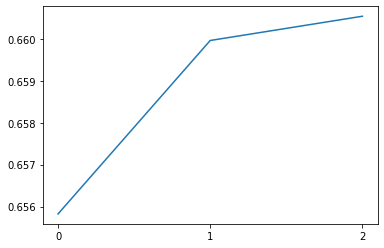

In [32]:
rem=['VIP', 'RoomService', 'FoodCourt']
scores = []
for i in range(len(rem)):
    score , _ , _ = trial(rem=rem[:i])
    scores.append(score)
    
plt.plot(range(len(scores)), scores)
plt.xticks(range(len(scores)))
plt.show() 

# And some Optuna tuned hyperparameters added in to improve those predicitions.

In [33]:
xgb_hyper_params = {'max_depth': 6, 'learning_rate': 0.0102657591775899, 'n_estimators': 219, 'subsample': 0.763387008801389, 'gamma': 3.8037093108929487, 'alpha': 0.9994007069133161, 'reg_lambda': 8.96253712351312}

In [34]:
def final(rem=['VIP', 'RoomService', 'FoodCourt']):
    df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
    df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
    
    # Merge to process together
    df = pd.concat([df_train, df_test], keys=['train','test'])
    
    # Preprocessing
    df = break_down(df)
    df = impute(df)
    df = encode(df)
    
    # Creating additional features
    df = create_features(df)
    
    # Removing some features, based on situational evidence and mutual informaion scores
    df = df.drop(rem, axis = 1)
    
    # Reform splits
    df_train = df.loc['train']
    df_train.set_index('PassengerId', inplace=True)
    df_test = df.loc['test']
    df_test.set_index('PassengerId', inplace=True)
    
    X = df_train.copy()
    y = X.pop('Transported')
    df_test.pop('Transported')
    
    model=XGBClassifier(max_depth= 6,
                        learning_rate= 0.0102657591775899,
                        n_estimators= 219,
                        subsample= 0.763387008801389,
                        gamma= 3.8037093108929487,
                        alpha= 0.9994007069133161,
                        reg_lambda = 8.96253712351312)
    model.fit(X,y)
    predictions = model.predict(df_test)
    output = pd.DataFrame({'PassengerId': df_test.index, 'Transported': predictions})
    output.replace({0:False,1:True},inplace=True)

    return output

In [35]:
output = final()

output

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [36]:
output.to_csv('submission.csv', index=False)